In [1]:
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('xnas-itch-nvidia-cake.csv')

# NVDA and CAKE Summary Statistics

In [2]:
# Split up and prepare dataset

# this is returning nothing
def prepare_bid_ask_data(df):
    """ Helper function to create bid_price, ask_price, bid_depth, and ask_depth columns
        that will be used for later summary statistic calculations."""
    
    # Create bid and ask price columns based on the 'side' column
    df['bid_price'] = df['price'].where(df['side'] == 'B', None)
    df['ask_price'] = df['price'].where(df['side'] == 'A', None)
        
    # Forward fill the missing bid and ask prices and depths
    df['bid_price'] = df['bid_price'].ffill()
    df['ask_price'] = df['ask_price'].ffill()
    
    return df

nvda_df = prepare_bid_ask_data(df[df['symbol'] == 'NVDA'].copy())
cake_df = prepare_bid_ask_data(df[df['symbol'] == 'CAKE'].copy())


In [3]:
nvda_df.columns

Index(['ts_recv', 'ts_event', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'depth', 'price', 'size', 'flags', 'ts_in_delta',
       'sequence', 'symbol', 'bid_price', 'ask_price'],
      dtype='object')

In [4]:
def calc_summary_statistics(df, name):
    ''' Driver function for (a) - (j)'''
    
    def calculate_5s_price_impact(df):
        ''' Helper function that contains logic to calculate 5 second price impact.'''

        # Calculate the midpoint price
        df['midpoint'] = (df['bid_price'] + df['ask_price']) / 2

        # Lag midpoint by 5 seconds
        df['midpoint_lag'] = df['midpoint'].shift(5)

        # Calculate the midpoint return
        df['midpoint_return'] = df['midpoint'] - df['midpoint_lag']

        # Create a trade sign column based on the 'side' (-1 for 'Ask', +1 for 'Bid')
        df['trade_sign'] = df['side'].apply(lambda x: 1 if x == 'B' else -1)

        # Remove NaN values that result from the shift
        clean = df.dropna(subset=['midpoint_return', 'trade_sign'])

        # Perform the regression of 5-second midpoint return on trade sign
        price_impact_model = sm.OLS(pd.to_numeric(clean['midpoint_return']), clean['trade_sign']).fit()

        # Display the summary of the regression model
        return price_impact_model.summary()


    def calculate_depth_at_twice_avg_spread(df):
        """ Calculate depth at twice the day's average spread per minute. """

        # Group by minute
        df['minute'] = pd.to_datetime(df['ts_event']).dt.floor('T')

        # Forward fill the missing bid and ask prices and depths
        df['bid_price'] = df['bid_price'].ffill()
        df['ask_price'] = df['ask_price'].ffill()

        # If bid or ask price is still NaN after forward filling, fill with the last available price
        df['bid_price'] = df['bid_price'].fillna(method='ffill')
        df['ask_price'] = df['ask_price'].fillna(method='ffill')

        # Calculate the spread for each event
        df['spread'] = df.apply(lambda row: row['ask_price'] - row['bid_price'], axis=1)

        # Calculate the daily average spread
        daily_avg_spread = df['spread'].mean()

        # Group by minute and calculate the depth based on the condition
        ask_depth_series = df.groupby('minute').apply(lambda group: calculate_ask_depth(group, daily_avg_spread))
        bid_depth_series = df.groupby('minute').apply(lambda group: calculate_bid_depth(group, daily_avg_spread))

        return ask_depth_series, bid_depth_series

    
    def calculate_ask_depth(group, daily_avg_spread):
        """ Calculate ask depth for a specific group given the daily average spread. """

        # Calculate the midpoint price
        group['midquote'] = (group['bid_price'] + group['ask_price']) / 2

        # Define threshold for the ask side
        ask_threshold = group['midquote'] + 2 * daily_avg_spread

        # Calculate depth on the ask side
        ask_depth = group[(group['side'] == 'A') & (group['price'] <= ask_threshold)]['size'].sum()

        return ask_depth

    def calculate_bid_depth(group, daily_avg_spread):
        """ Calculate bid depth for a specific group given the daily average spread. """

        # Calculate the midpoint price
        group['midquote'] = (group['bid_price'] + group['ask_price']) / 2

        # Define threshold for the bid side
        bid_threshold = group['midquote'] - 2 * daily_avg_spread

        # Calculate depth on the bid side
        bid_depth = group[(group['side'] == 'B') & (group['price'] >= bid_threshold)]['size'].sum()

        return bid_depth

    
    def calculate_bbo_spread_and_depth_per_minute(df):
        ''' Calculate the best BBO spread and depth per minute from the provided DataFrame. '''

        # Group by minute
        df['minute'] = pd.to_datetime(df['ts_event']).dt.floor('T')

        # Initialize lists to store results
        minutes = []
        best_bbo_spreads = []
        best_bbo_depths = []

        # Initialize variables to keep track of the last available bid and ask prices
        last_bid_price = None
        last_ask_price = None
        last_bid_depth = 0
        last_ask_depth = 0

        # Group by each minute
        grouped = df.groupby('minute')

        for minute, group in grouped:
            # Identify the best bid and ask prices in the minute
            best_bid_price = group[group['side'] == 'B']['price'].max() if not group[group['side'] == 'B'].empty else last_bid_price
            best_ask_price = group[group['side'] == 'A']['price'].min() if not group[group['side'] == 'A'].empty else last_ask_price

            # If bid or ask is missing, use the last available values
            if pd.isna(best_bid_price):
                best_bid_price = last_bid_price
            if pd.isna(best_ask_price):
                best_ask_price = last_ask_price

            # Calculate the BBO spread
            if pd.notna(best_bid_price) and pd.notna(best_ask_price):
                bbo_spread = abs(best_ask_price - best_bid_price)
            else:
                bbo_spread = None

            # Calculate the BBO depth
            best_bid_depth = group[(group['side'] == 'B') & (group['price'] == best_bid_price)]['size'].sum() if not group[group['side'] == 'B'].empty else last_bid_depth
            best_ask_depth = group[(group['side'] == 'A') & (group['price'] == best_ask_price)]['size'].sum() if not group[group['side'] == 'A'].empty else last_ask_depth
            bbo_depth = best_bid_depth + best_ask_depth

            # Update the last bid and ask prices and depths
            last_bid_price = best_bid_price
            last_ask_price = best_ask_price
            last_bid_depth = best_bid_depth
            last_ask_depth = best_ask_depth

            # Store the results
            minutes.append(minute)
            best_bbo_spreads.append(bbo_spread)
            best_bbo_depths.append(bbo_depth)

        # Create a DataFrame for the results
        best_bbo_spread = dict(zip(minutes, best_bbo_spreads))
        best_bbo_depth = dict(zip(minutes, best_bbo_depths))

        return best_bbo_spread, best_bbo_depth
    
    
    def calculate_5s_price_impact_per_minute(df, common_minute_index):
        """
        Helper function to calculate 5-second price impact per minute by regressing the 5-second midpoint quote return 
        on the current trade sign (-1 or +1) according to the formula in the screenshot.
        Returns a list of the price impacts after being reindexed to match the common minute index.
        """

        # Ensure ts_event is datetime and set it as the index
        df['ts_event'] = pd.to_datetime(df['ts_event'])
        df.set_index('ts_event', inplace=True)

        # Calculate the midpoint price
        df['midpoint'] = (df['bid_price'] + df['ask_price']) / 2

        # Aggregate by second to avoid duplicate labels
        df = df.resample('1S').last()

        # Forward fill missing data after resampling
        df = df.ffill()

        # Lag midpoint by 5 seconds
        df['midpoint_lag'] = df['midpoint'].shift(5)

        # Calculate the 5-second midpoint return as a percentage change
        df['midpoint_return'] = (df['midpoint'] - df['midpoint_lag']) / df['midpoint_lag']

        # Create a trade sign column based on the 'side' (-1 for 'Ask', +1 for 'Bid')
        df['trade_sign'] = df['side'].apply(lambda x: 1 if x == 'Bid' else -1).ffill()

        # Remove NaN values that result from the shift
        df = df.dropna(subset=['midpoint_return', 'trade_sign'])

        # Group by minute
        df['minute'] = df.index.floor('T')

        # Initialize a list to store the results
        price_impact_results = []

        # Perform regression for each minute
        grouped = df.groupby('minute')

        for minute, group in grouped:
            # Perform the regression of 5-second midpoint return on trade sign
            model = sm.OLS(group['midpoint_return'], sm.add_constant(group['trade_sign'])).fit()
            # Extract the regression coefficient for trade sign (price impact)
            price_impact = model.params['trade_sign']
            # Store the result in a list with the minute as the index
            price_impact_results.append({'minute': minute, 'price_impact': price_impact})

        # Convert the results into a DataFrame
        price_impact_df = pd.DataFrame(price_impact_results)
        price_impact_df.set_index('minute', inplace=True)

        # Reindex to match the common minute index
        price_impact_df = price_impact_df.reindex(common_minute_index, fill_value=0)

        # Return the list of price impacts after reindexing
        return price_impact_df['price_impact'].tolist()


    def calculate_midquote_transaction(df):
        ''' Helper function to calculate one-second and one-minute midquote and transaction price series.'''

        # Ensure ts_event is datetime and set it as the index
        df['ts_event'] = pd.to_datetime(df['ts_event'])
        df.set_index('ts_event', inplace=True)

        # Calculate the midpoint price
        
        # get the highest bid and lowest ask for each minute
        
        # and then calculate the midpoint based on that
        df['midpoint'] = (df['bid_price'] + df['ask_price']) / 2

        # Resample the data to one-second and one-minute intervals, taking the last value in each interval
        midquote_1sec = df['midpoint'].resample('1S').last()
        midquote_1min = df['midpoint'].resample('1T').last()

        # For transaction prices
        transaction_1sec = df['price'].resample('1S').last()
        transaction_1min = df['price'].resample('1T').last()
        
        
        # Drop the first NaN value
        midquote_1sec.dropna(inplace=True)
        midquote_1min.dropna(inplace=True)
        transaction_1sec.dropna(inplace=True)
        transaction_1min.dropna(inplace=True)


        return midquote_1sec, midquote_1min, transaction_1sec, transaction_1min

    
    def calculate_log_returns(midquote_1_min, transaction_1min):
        ''' Helper function to calculate log returns.'''
        
        midquote_log_return_1min = np.log(midquote_1min) - np.log(midquote_1min.shift(1))
        transaction_log_return_1min = np.log(transaction_1min) - np.log(transaction_1min.shift(1))

        # Drop NaN values resulting from the shift
        midquote_log_return_1min = midquote_log_return_1min.dropna()
        transaction_log_return_1min = transaction_log_return_1min.dropna()

        # Display the first few log-returns
        return midquote_log_return_1min, transaction_log_return_1min
    

    # Initialize results table
    results = {}
    results_1s = {}

    # Get the common minute index
    minute_index = pd.to_datetime(df['ts_event']).dt.floor('T').unique()

    # (a) Dollar trading volume per minute
    df['dollar_vol'] = df['price'] * df['size']
    dtv=df.groupby(pd.to_datetime(pd.to_datetime(df['ts_event'])).dt.floor('min'))['dollar_vol'].sum()
    results['dollar_vol'] = dtv
    dtv.plot(title=name + ' Dollar Volume Per Minute', logy=True)
    plt.show()


    # (b) Number of trades and number of orders per minute
    tpm=df.groupby(pd.to_datetime(df['ts_event']).dt.floor('min'))['sequence'].count()
    results['number_trades_per_min'] = tpm
    tpm.plot(title = name + ' Number Trades per Minute')
    plt.show()
    
    # I don't think I can get this - add shashwat code?
    #number_orders_per_min = df['sequence'].nunique() / len(minute_index)
    #results['number_orders_per_min'] = df.groupby(pd.to_datetime(df['ts_event']).dt.floor('min'))['dollar_vol'].sum()
    #plt.plot(results['number_orders_per_min'], logy=True)
    #plt.show()

    # (c) Open, close, high, and low prices
    stock_open = df.iloc[0]['price']
    close = df.iloc[-1]['price']
    high = df['price'].max()
    low = df['price'].min()
    
    print(name + ' Open: ', stock_open)
    print(name + ' Close: ', close)
    print(name + ' High: ', close)
    print(name + ' Low: ', close)


    # (d) VWAP per minute
    vwap_per_min = df.groupby(pd.to_datetime(df['ts_event']).dt.floor('T')).apply(
        lambda x: (x['price'] * x['size']).sum() / x['size'].sum())
    results['vwap'] = vwap_per_min.reindex(minute_index, fill_value=0)
    vwap_per_min.plot(title=name + ' VWAP per Minute')
    plt.show()

    # (e) BBO spread and depth per minute - NEEDS TO BE FIXED
    best_bbo_spread, best_bbo_depth = calculate_bbo_spread_and_depth_per_minute(df)
    results['best_bbo_spread'] = pd.Series(best_bbo_spread).reindex(minute_index, fill_value=0)
    results['best_bbo_depth'] = pd.Series(best_bbo_depth).reindex(minute_index, fill_value=0)
    
    results['best_bbo_spread'].plot(title=name + ' Best BBO Spread per Minute')
    plt.show()
    results['best_bbo_depth'].plot(title=name + ' Best BBO Depth per Minute')
    plt.show()

    # (f) Depth at twice that day’s average spread - NEEDS TO BE FIXED
    ask_depth_series, bid_depth_series = calculate_depth_at_twice_avg_spread(df)
    results['depth_twice_avg_spread_ask'] = ask_depth_series
    results['depth_twice_avg_spread_bid'] = bid_depth_series

    # (g) 5-second price impact per minute
    minute_index = pd.to_datetime(df['ts_event']).dt.floor('T').unique()
    
    fives_price_impact = calculate_5s_price_impact_per_minute(df.copy(), minute_index)
    results['5s_price_impact'] = fives_price_impact
    
    plt.plot(fives_price_impact)
    plt.title(name + ' Five Second Price Impact')
    plt.show()
    
    # (h) Midquote and transaction price series
    midquote_1sec, midquote_1min, transaction_1sec, transaction_1min = calculate_midquote_transaction(df.copy())
    results_1s['midquote_1sec'] = midquote_1sec
    results_1s['transaction_1sec'] = transaction_1sec
    results['midquote_1min'] = midquote_1min.reindex(minute_index, fill_value=0)
    results['transaction_1min'] = transaction_1min.reindex(minute_index, fill_value=0)
    
    plt.plot(midquote_1sec, label='Midquote 1-sec' )
    plt.plot(transaction_1sec, label='Transaction 1-sec')
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-sec')
    plt.show()
    
    plt.plot(midquote_1min, label='Midquote 1-min' )
    plt.plot(transaction_1min, label='Transaction 1-min')
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-min')
    plt.show()

    # (i) Log returns
    midquote_log_return_1min, transaction_log_return_1min = calculate_log_returns(midquote_1min, transaction_1min)
    results['midquote_log_return_1min'] = midquote_log_return_1min.reindex(minute_index, fill_value=0)
    results['transaction_log_return_1min'] = transaction_log_return_1min.reindex(minute_index, fill_value=0)
    
    plt.plot(results['midquote_log_return_1min'])
    plt.title(name + ' Midquote Log Returns 1-min')
    plt.show()
    
    plt.plot(results['transaction_log_return_1min'])
    plt.title(name + ' Midquote Transaction Returns 1-min')
    plt.show()
    
    # (j) Realized variance
    midquote_realized_variance = (midquote_log_return_1min ** 2).sum()
    results['midquote_realized_variance'] = midquote_realized_variance
    
    # TODO add transaction realized variance
    
    plt.plot(results['midquote_realized_variance'])
    plt.title(name + ' Midquote Realized Variance')
    plt.show()

    # Convert results to DataFrame
        
    min_stats = pd.DataFrame(results)
    sec_stats = pd.DataFrame(results_1s)

    # (k) Auto-correlation for midquote and transaction returns
    midquote_pacf = pacf(midquote_log_return_1min)
    transaction_pacf = pacf(transaction_log_return_1min)

    return min_stats, sec_stats, midquote_pacf, transaction_pacf


# NVDA Summary Statistics

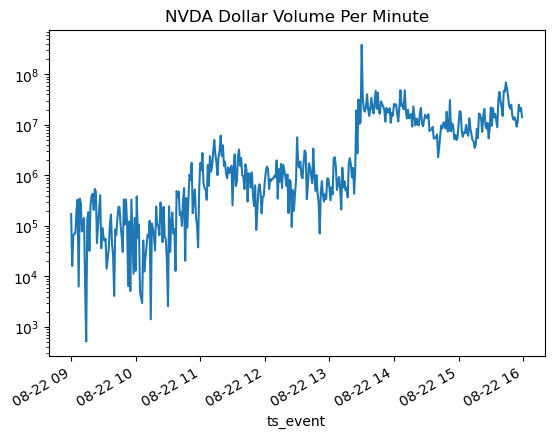

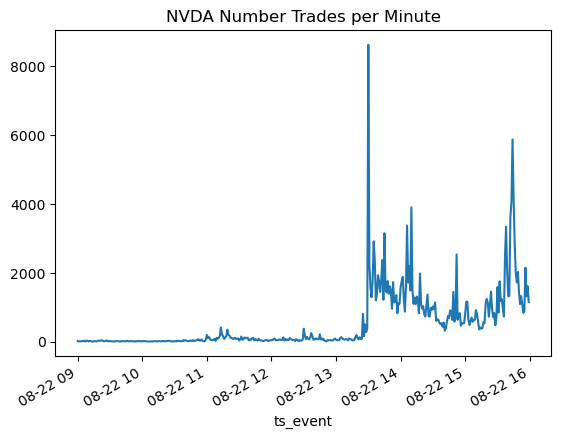

NVDA Open:  128.63
NVDA Close:  125.61
NVDA High:  125.61
NVDA Low:  125.61


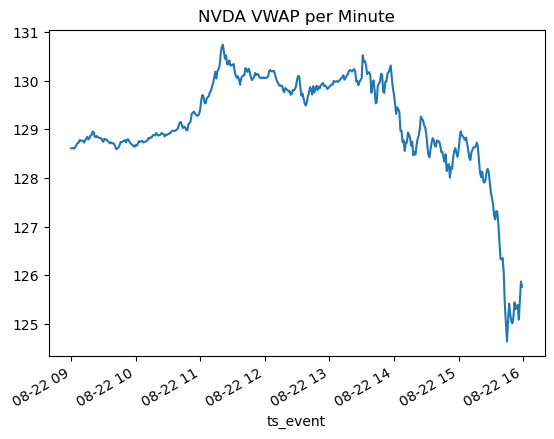

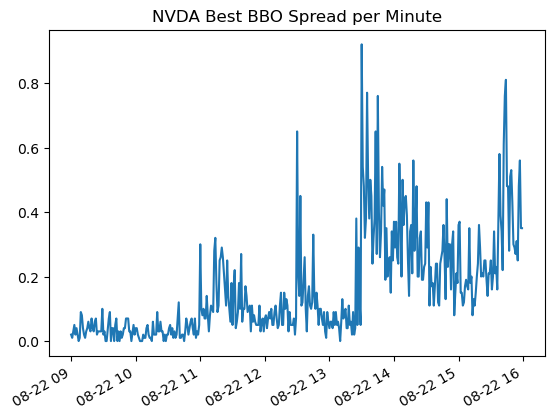

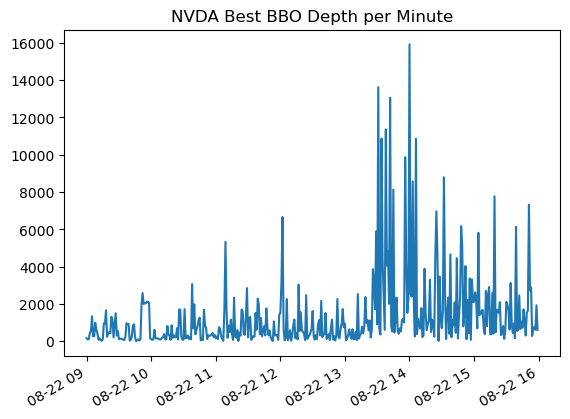

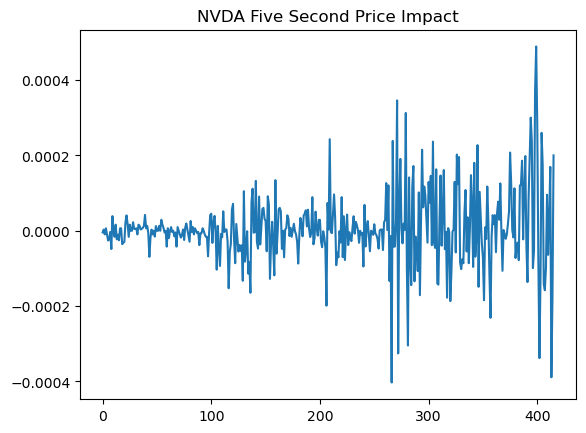

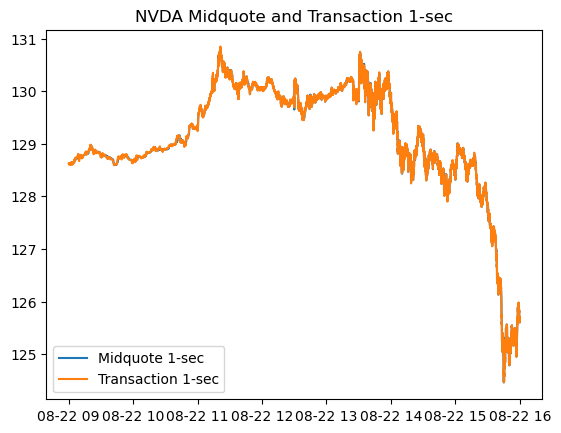

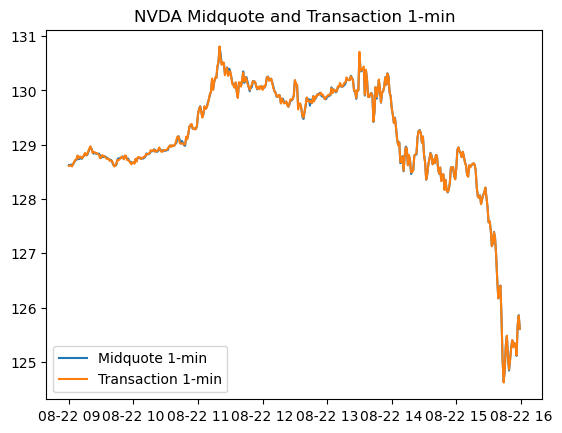

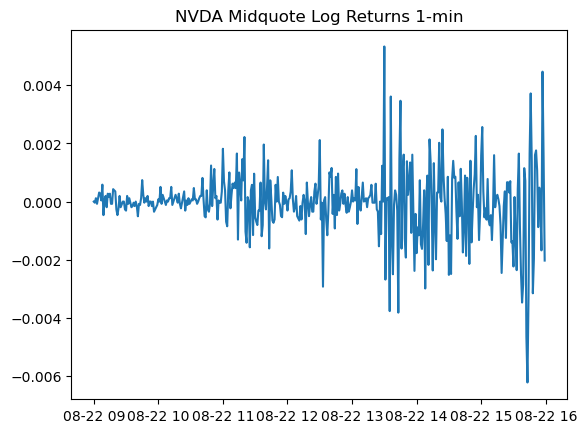

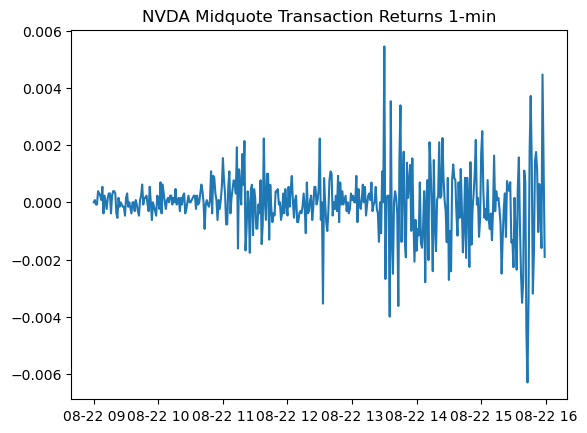

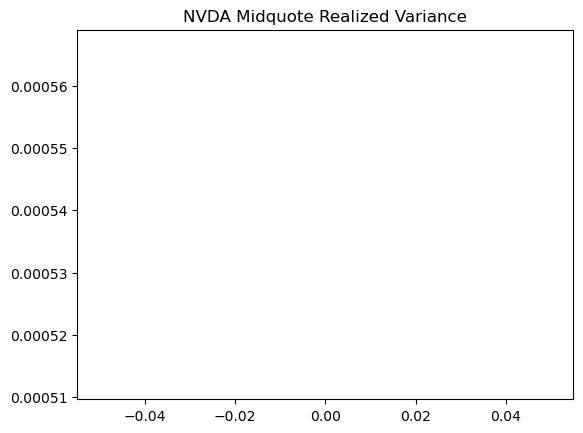

In [5]:
min_stats, sec_stats, midquote_pacf, transaction_pacf = calc_summary_statistics(nvda_df, 'NVDA')

In [6]:
sec_stats.head(10)

,midquote_1sec,transaction_1sec
ts_event,,
2024-08-22 09:00:11+00:00,NaN,128.63
2024-08-22 09:00:12+00:00,128.620,128.61
2024-08-22 09:00:19+00:00,128.625,128.62
2024-08-22 09:00:25+00:00,128.625,128.62
2024-08-22 09:00:26+00:00,128.625,128.62
2024-08-22 09:00:38+00:00,128.625,128.62
2024-08-22 09:00:40+00:00,128.625,128.62
2024-08-22 09:00:44+00:00,128.625,128.62
2024-08-22 09:00:48+00:00,128.625,128.62


In [7]:
print('(K) Autocorrelation for midquote and transaction returns')

print('Midquote return autocorrelations')
print(midquote_pacf)

print('\n\nTransaction return autocorrelations')
print(transaction_pacf)


(K) Autocorrelation for midquote and transaction returns
Midquote return autocorrelations
[ 1.00000000e+00  7.22534526e-02 -1.34167359e-01 -3.08815198e-02
  1.91689224e-02  4.16881282e-02  1.83715931e-01 -6.09642770e-02
 -5.65628874e-02 -2.67192962e-02  1.50537850e-02  1.65506315e-01
  5.72440645e-02 -6.04378300e-02 -1.18278737e-03 -2.71744472e-03
 -8.66985917e-02 -7.47156444e-02 -2.13133570e-02  5.84451671e-02
  2.72945722e-02 -7.43170483e-04  2.02785407e-02  6.97074097e-03
  2.33588517e-02  3.17885161e-02  4.84009096e-02]


Transaction return autocorrelations
[ 1.00000000e+00  6.00847530e-02 -1.28197090e-01 -3.04166863e-02
  1.97797621e-02  5.29437961e-02  1.77711799e-01 -6.05048789e-02
 -5.51132786e-02 -3.36847427e-02  1.71885951e-02  1.49026548e-01
  7.80841901e-02 -7.29162560e-02  1.21543968e-02  2.73917997e-03
 -1.03519186e-01 -7.70167698e-02 -1.63661014e-02  5.75065849e-02
  2.79005326e-02 -5.21237014e-05  4.09007824e-02 -3.22893096e-03
  2.83531841e-02  1.84034803e-02  3.815207

# CAKE Summary Statistics

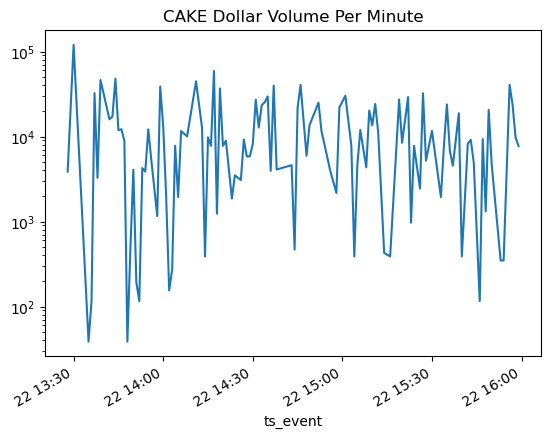

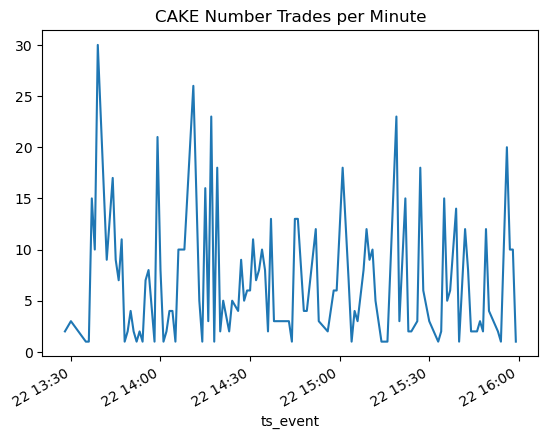

CAKE Open:  38.76
CAKE Close:  38.7
CAKE High:  38.7
CAKE Low:  38.7


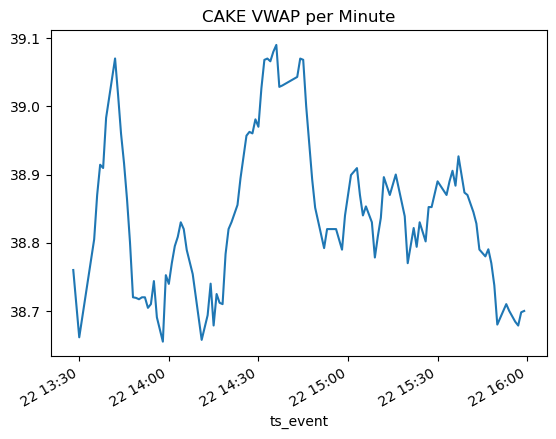

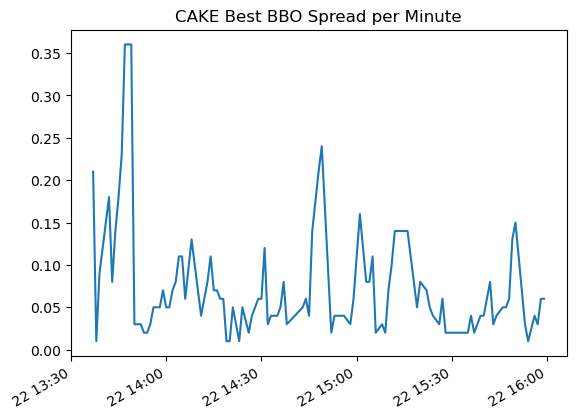

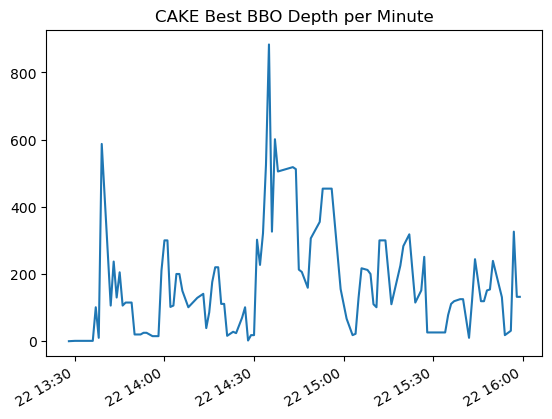

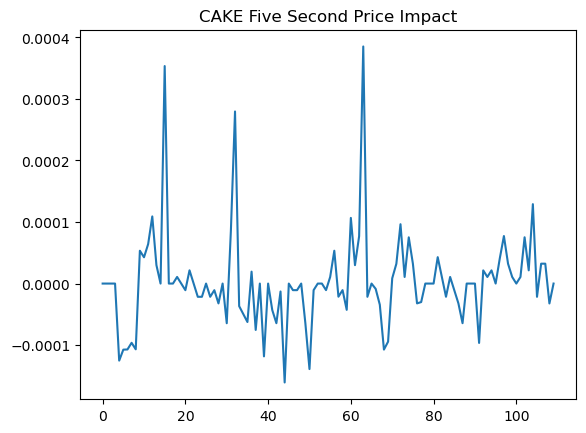

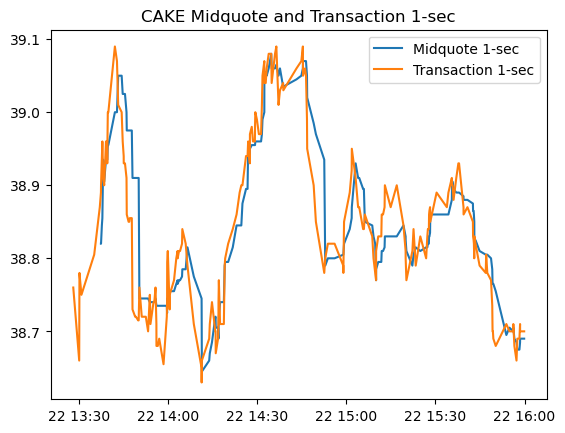

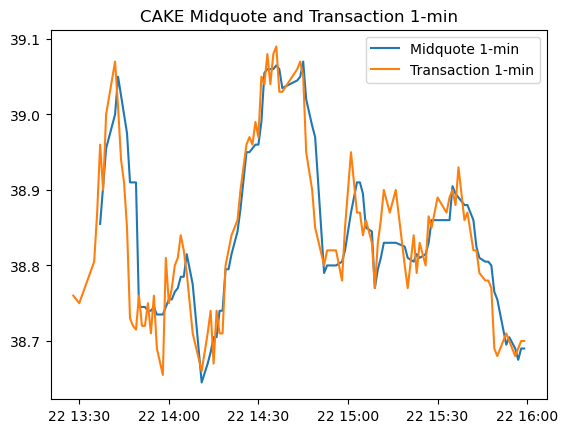

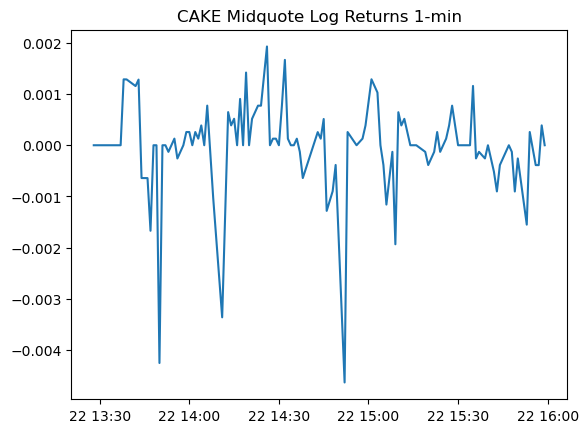

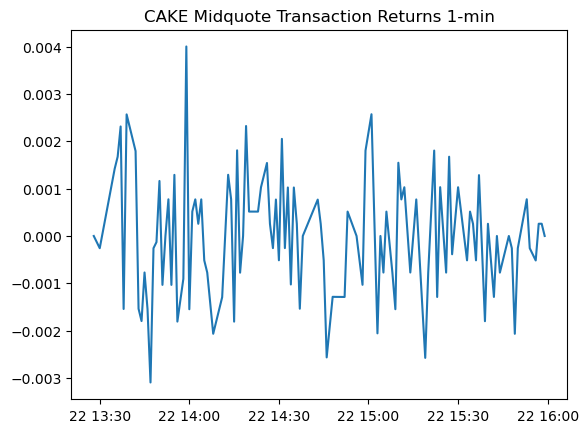

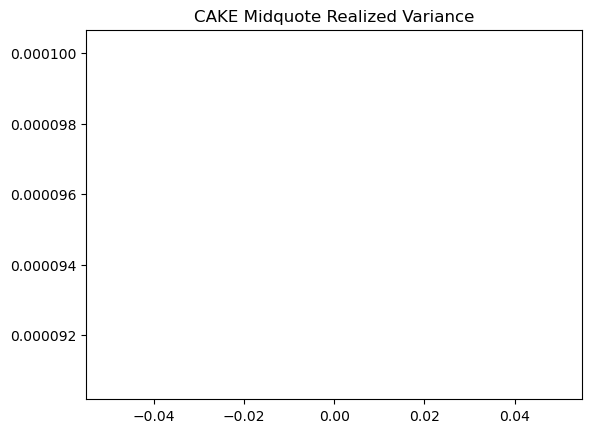

In [8]:
min_stats, sec_stats, midquote_pacf, transaction_pacf = calc_summary_statistics(cake_df, 'CAKE')

In [9]:
min_stats.head(10)

,dollar_vol,number_trades_per_min,vwap,best_bbo_spread,best_bbo_depth,depth_twice_avg_spread_ask,depth_twice_avg_spread_bid,5s_price_impact,midquote_1min,transaction_1min,midquote_log_return_1min,transaction_log_return_1min,midquote_realized_variance
2024-08-22 13:28:00+00:00,3876.000,2,38.760000,NaN,0,0,0,0.000000,0.000,38.760,0.000000,0.000000,0.000095
2024-08-22 13:30:00+00:00,119695.530,3,38.661347,NaN,1,0,0,0.000000,0.000,38.750,0.000000,-0.000258,0.000095
2024-08-22 13:35:00+00:00,38.805,1,38.805000,NaN,1,0,0,0.000000,0.000,38.805,0.000000,0.001418,0.000095
2024-08-22 13:36:00+00:00,116.610,1,38.870000,NaN,1,0,0,0.000000,0.000,38.870,0.000000,0.001674,0.000095
2024-08-22 13:37:00+00:00,32415.640,15,38.914334,0.21,101,0,0,-0.000125,38.855,38.960,0.000000,0.002313,0.000095
2024-08-22 13:38:00+00:00,3268.400,10,38.909524,0.01,10,0,0,-0.000107,38.905,38.900,0.001286,-0.001541,0.000095
2024-08-22 13:39:00+00:00,46272.970,30,38.983126,0.09,587,0,0,-0.000107,38.955,39.000,0.001284,0.002567,0.000095
2024-08-22 13:42:00+00:00,15940.610,9,39.070123,0.18,106,0,0,-0.000096,39.000,39.070,0.001155,0.001793,0.000095
2024-08-22 13:43:00+00:00,17206.470,13,39.016939,0.08,237,0,0,-0.000107,39.050,39.010,0.001281,-0.001537,0.000095
2024-08-22 13:44:00+00:00,48076.360,17,38.959773,0.14,130,0,0,0.000053,39.025,38.940,-0.000640,-0.001796,0.000095


In [10]:
sec_stats.head(10)

,midquote_1sec,transaction_1sec
ts_event,,
2024-08-22 13:28:00+00:00,NaN,38.760
2024-08-22 13:30:00+00:00,NaN,38.660
2024-08-22 13:30:05+00:00,NaN,38.780
2024-08-22 13:30:45+00:00,NaN,38.750
2024-08-22 13:35:03+00:00,NaN,38.805
2024-08-22 13:36:56+00:00,NaN,38.870
2024-08-22 13:37:19+00:00,38.820,38.890
2024-08-22 13:37:21+00:00,38.820,38.900
2024-08-22 13:37:38+00:00,38.845,38.940


In [11]:
print('(K) Autocorrelation for midquote and transaction returns')

print('Midquote return autocorrelations')
print(midquote_pacf)

print('\n\nTransaction return autocorrelations')
print(transaction_pacf)

(K) Autocorrelation for midquote and transaction returns
Midquote return autocorrelations
[ 1.00000000e+00  1.60081774e-01  1.01974872e-01  9.34251267e-02
 -9.93811437e-02 -9.08372237e-02 -3.20864483e-02  7.04542369e-05
 -7.59195925e-04  2.79349555e-02 -6.77875439e-02  9.55288082e-02
 -1.86470424e-01 -1.49371577e-01  2.20381621e-02  2.72949775e-02
  9.16769295e-02  6.14758716e-02 -1.39664339e-01 -1.76077556e-01
  5.62966834e-02]


Transaction return autocorrelations
[ 1.         -0.0818327   0.03214951  0.13735142  0.01604048 -0.0062993
 -0.21053409 -0.04256237 -0.08376523  0.04093482  0.00819101  0.16415715
 -0.29302945 -0.10457776 -0.06791821 -0.09752999  0.06309707  0.0313693
 -0.08477849  0.0875234  -0.04883695]
